## Best Gaussian process regression model selection through cross validation <br>
Reference : <br>
https://datachemeng.com/kernel_design_in_gpr/ <br>
https://upura.hatenablog.com/entry/2018/12/04/224436

### Import library and dataset

In [46]:
# import libraries
%matplotlib inline
%pylab inline  
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# GPR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, ConstantKernel, WhiteKernel

# Cross validation
from sklearn.model_selection import (KFold, ShuffleSplit)
from sklearn.metrics import mean_squared_error, r2_score

Populating the interactive namespace from numpy and matplotlib


C:\Users\mmm\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [47]:
# load dataset as pandas dataframe
#df = pd.read_csv('03_df_selected_cluster_0.csv')
df = pd.read_csv('auto-mpg_clean.csv')
print(df.shape)
df.head()

(383, 7)


,car name,mpg,cylinders,displacement,horsepower,weight,acceleration
0,chevrolet chevelle malibu,18.0,8.0,307.0,130.0,3504.0,12.0
1,buick skylark 320,15.0,8.0,350.0,165.0,3693.0,11.5
2,plymouth satellite,18.0,8.0,318.0,150.0,3436.0,11.0
3,amc rebel sst,16.0,8.0,304.0,150.0,3433.0,12.0
4,ford torino,17.0,8.0,302.0,140.0,3449.0,10.5


In [48]:
df_test = df.drop(df.columns[[0]], axis=1)
print(df_test.shape)
df_test.head()

(383, 6)


,mpg,cylinders,displacement,horsepower,weight,acceleration
0,18.0,8.0,307.0,130.0,3504.0,12.0
1,15.0,8.0,350.0,165.0,3693.0,11.5
2,18.0,8.0,318.0,150.0,3436.0,11.0
3,16.0,8.0,304.0,150.0,3433.0,12.0
4,17.0,8.0,302.0,140.0,3449.0,10.5


In [49]:
X = df_test.iloc[:, 1:]
y = df_test.iloc[:, :1]

In [50]:
X.head()

,cylinders,displacement,horsepower,weight,acceleration
0,8.0,307.0,130.0,3504.0,12.0
1,8.0,350.0,165.0,3693.0,11.5
2,8.0,318.0,150.0,3436.0,11.0
3,8.0,304.0,150.0,3433.0,12.0
4,8.0,302.0,140.0,3449.0,10.5


In [51]:
y.head()

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


In [52]:
n_features = len(X.columns)
n_features

5

In [53]:
# dictionary of kernel
kernel_dict = {0:ConstantKernel() * DotProduct() + WhiteKernel(),
               1:ConstantKernel() * RBF() + WhiteKernel(),
               2:ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
               3:ConstantKernel() * RBF(np.ones(n_features)) + WhiteKernel(),
               4:ConstantKernel() * RBF(np.ones(n_features)) + WhiteKernel() + ConstantKernel() * DotProduct(),
               5:ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
               6:ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
               7:ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
               8:ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
               9:ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
               10:ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()}

### List of scores by KFold and Shaffle split

In [54]:
score_mean_KF = list()
score_mean_SS = list()

In [55]:
split_num = 5

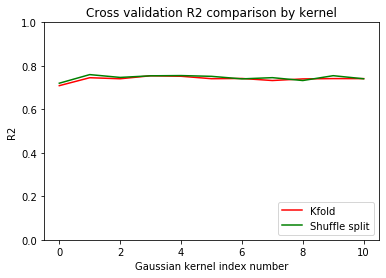

In [56]:
with np.errstate(invalid='ignore'):
    for i in kernel_dict.keys():
        kern = kernel_dict[i]
        cv_KF = KFold(n_splits = split_num, shuffle = True, random_state = 0)
        score_temp_KF = list()
        
        for train_index, test_index in cv_KF.split(X):
            X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
            gaussr = GaussianProcessRegressor(kernel=kern).fit(X_train, y_train)

            y_pred = gaussr.predict(X_test)
            R2_gauss = r2_score(y_test, y_pred)
            score_temp_KF.append(R2_gauss)
        score_mean_KF.append(np.mean(score_temp_KF))
        
    for j in kernel_dict.keys():
        kern = kernel_dict[j]
        cv_SS = ShuffleSplit(n_splits = split_num, random_state = 0, test_size=0.2, train_size=None)
        score_temp_SS = list()
        for train_index, test_index in cv_SS.split(X):
            X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
            gaussr = GaussianProcessRegressor(kernel=kern).fit(X_train, y_train)

            y_pred = gaussr.predict(X_test)
            R2_gauss = r2_score(y_test, y_pred)
            score_temp_SS.append(R2_gauss)
        score_mean_SS.append(np.mean(score_temp_SS))

plt.plot(score_mean_KF, c = 'r', label = 'Kfold')
plt.plot(score_mean_SS, c = 'g', label = 'Shuffle split')
plt.title('Cross validation R2 comparison by kernel')
plt.xlabel('Gaussian kernel index number')
plt.ylabel('R2'), plt.ylim(0.0, 1.0)
plt.legend(loc = 'lower right')
plt.show()

In [57]:
print('kernel index', 'KFold R2', 'ShuffleSplit R2', sep = '\t')
for i in kernel_dict.keys():
    print(i, '', ' {:.4}'.format(score_mean_KF[i]), '', ' {:.4}'.format(score_mean_SS[i]), sep = '\t')

kernel index	KFold R2	ShuffleSplit R2
0		 0.7089		 0.7201
1		 0.7454		 0.7597
2		 0.7406		 0.7468
3		 0.7544		 0.7542
4		 0.7521		 0.7553
5		 0.7409		 0.7518
6		 0.7419		 0.7401
7		 0.7325		 0.7457
8		 0.7399		 0.7325
9		 0.7414		 0.7547
10		 0.7412		 0.7406


### Best model selection

In [58]:
best_kernel_index = score_mean_SS.index(np.max(score_mean_SS))
print('Best kernel index (highest R2) = ', best_kernel_index)

Best kernel index (highest R2) =  1


In [59]:
best_gaussr = GaussianProcessRegressor(kernel = kernel_dict[best_kernel_index]).fit(X, y)

In [60]:
# Save the best model
import pickle
with open('best_gaussr_sklearn.pickle', mode='wb') as f:
    pickle.dump(best_gaussr, f)

### Recall the model and check the fit

In [69]:
with open('best_gaussr_sklearn.pickle', mode='rb') as f:
    best_gaussr_recall = pickle.load(f)

In [70]:
y_pred = best_gaussr_recall.predict(X).reshape(-1, 1)
y_pred[:5]

array([[17.40024127],
       [14.91278276],
       [16.16037347],
       [16.17385825],
       [16.84695299]])

R2 =   0.7598


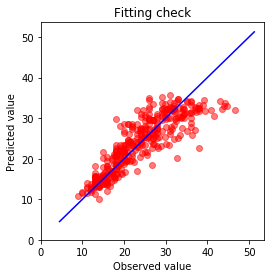

In [71]:
# For all
print('R2 = ', ' {:.4}'.format(r2_score(y, y_pred)))

plt.figure(figsize = [4, 4])
slp_1_begin = 0.5 * y.min()
slp_1_end   = 1.1 * y.max()

plt.scatter(y, y_pred, c = 'r', alpha = 0.5)
plt.plot([slp_1_begin, slp_1_end], [slp_1_begin, slp_1_end], c = 'b')
plt.title('Fitting check')
plt.xlim(0,), plt.xlabel('Observed value')
plt.ylim(0,), plt.ylabel('Predicted value')
plt.show()

In [72]:
# By validation set
print('Check best model perfromance in folds')
for train_index, test_index in cv_KF.split(X):
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
    y_pred = best_gaussr_recall.predict(X_test)
    R2_gauss = r2_score(y_test, y_pred)
    print(' {:.4}'.format(R2_gauss))

Check best model perfromance in folds
 0.8011
 0.7692
 0.6364
 0.7934
 0.7751
